# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [1]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression()

Let's visualize the training dataset and the learned regression model.

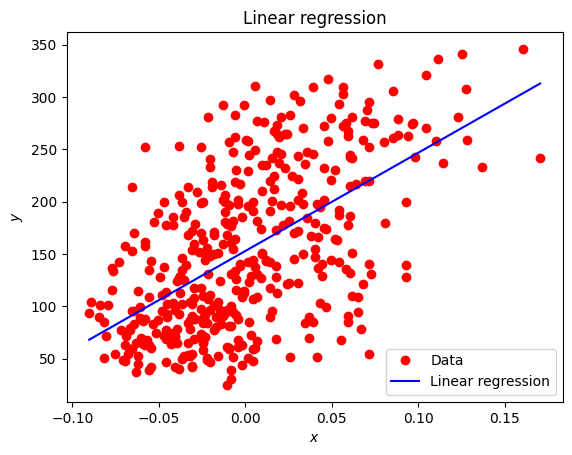

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [3]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [6]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

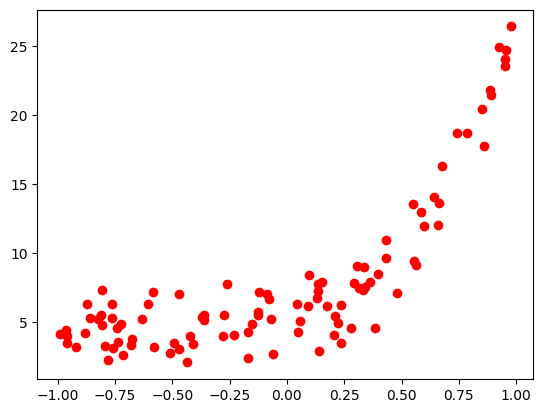

In [7]:
%matplotlib inline

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X, y, 'r.', markersize=12)

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

Plot a learning curve that show the validation accuracy as a function of the polynomial order. 

<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>
    
Repeat this experiment, this time using the diabetes dataset instead of the generated data.

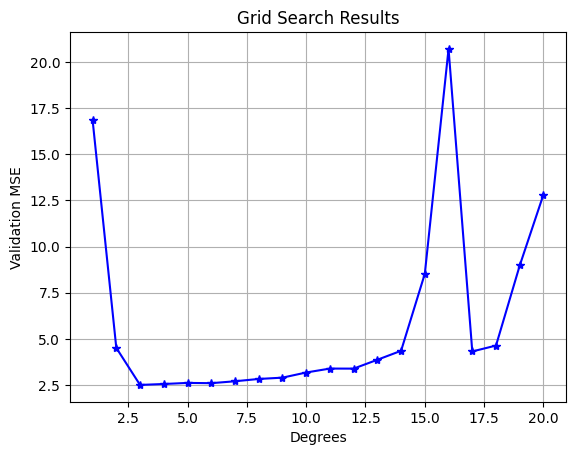

Best polynomial degree: 3


In [8]:
# Split the data into a training and test set
# Train size = 1/2, validation size = 1/4, test size = 1/4
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, train_size=0.5, random_state=42)

# Get polynomial features & perform grid search
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Grid search parameters
poly = PolynomialFeatures() # Initialize model
degree = np.arange(1, 21) # Degree 1 to 10
param_grid = {"poly__degree": degree} # Parameter grid
cv = 5 # 5-fold cross-validation

# Construct a pipeline
pipeline = Pipeline([
    ("poly", poly),
    ("regressor", LinearRegression())
]
)

# Grid search process
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error") # Initialize grid search

grid_search.fit(X_train.reshape(-1, 1), y_train)

# Extract and print scores for each degree
cv_results = grid_search.cv_results_
mean_scores = cv_results['mean_test_score'] * -1
std_scores = cv_results['std_test_score']
degrees = cv_results['param_poly__degree']

# # Print the mean scores and standard deviations for each degree
# for degree, mean, std in zip(degrees, mean_scores, std_scores):
#     print(f"Degree: {degree}, Mean Negative MSE: {mean:.4f}, Std: {std:.4f}")

# Plot results for each degree
plt.figure()
plt.plot(degrees, mean_scores, marker="*", color='blue')
plt.title("Grid Search Results")
plt.xlabel("Degrees")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.show()

best_degree = grid_search.best_params_["poly__degree"]
print(f"Best polynomial degree: {best_degree}")


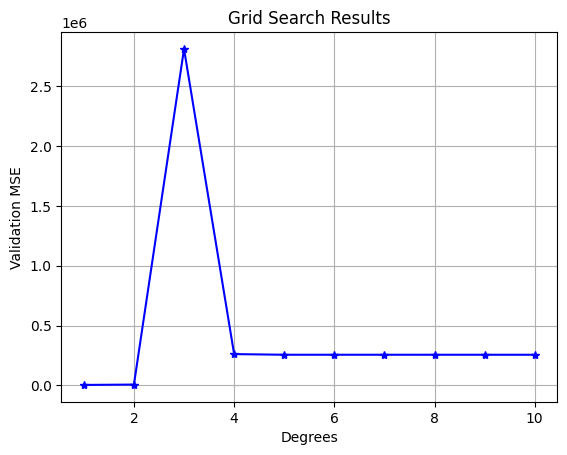

Best polynomial degree: 1


In [9]:
X = datasets.load_diabetes().data
y = datasets.load_diabetes().target

# Split the data into a training and test set
# Train size = 1/2, validation size = 1/4, test size = 1/4
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, train_size=0.5, random_state=42)

# Get polynomial features & perform grid search
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Grid search parameters
poly = PolynomialFeatures() # Initialize model
degree = np.arange(1, 11) # Degree 1 to 10
param_grid = {"poly__degree": degree} # Parameter grid
cv = 3 # 5-fold cross-validation

# Construct a pipeline
pipeline = Pipeline([
    ("poly", poly),
    ("regressor", LinearRegression())
]
)

# Grid search process
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error") # Initialize grid search

grid_search.fit(X_train, y_train)

# Extract and print scores for each degree
cv_results = grid_search.cv_results_
mean_scores = cv_results['mean_test_score'] * -1
std_scores = cv_results['std_test_score']
degrees = cv_results['param_poly__degree']

# # Print the mean scores and standard deviations for each degree
# for degree, mean, std in zip(degrees, mean_scores, std_scores):
#     print(f"Degree: {degree}, Mean Negative MSE: {mean:.4f}, Std: {std:.4f}")

# Plot results for each degree
plt.figure()
plt.plot(degrees, mean_scores, marker="*", color='blue')
plt.title("Grid Search Results")
plt.xlabel("Degrees")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.show()

best_degree = grid_search.best_params_["poly__degree"]
print(f"Best polynomial degree: {best_degree}")


### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

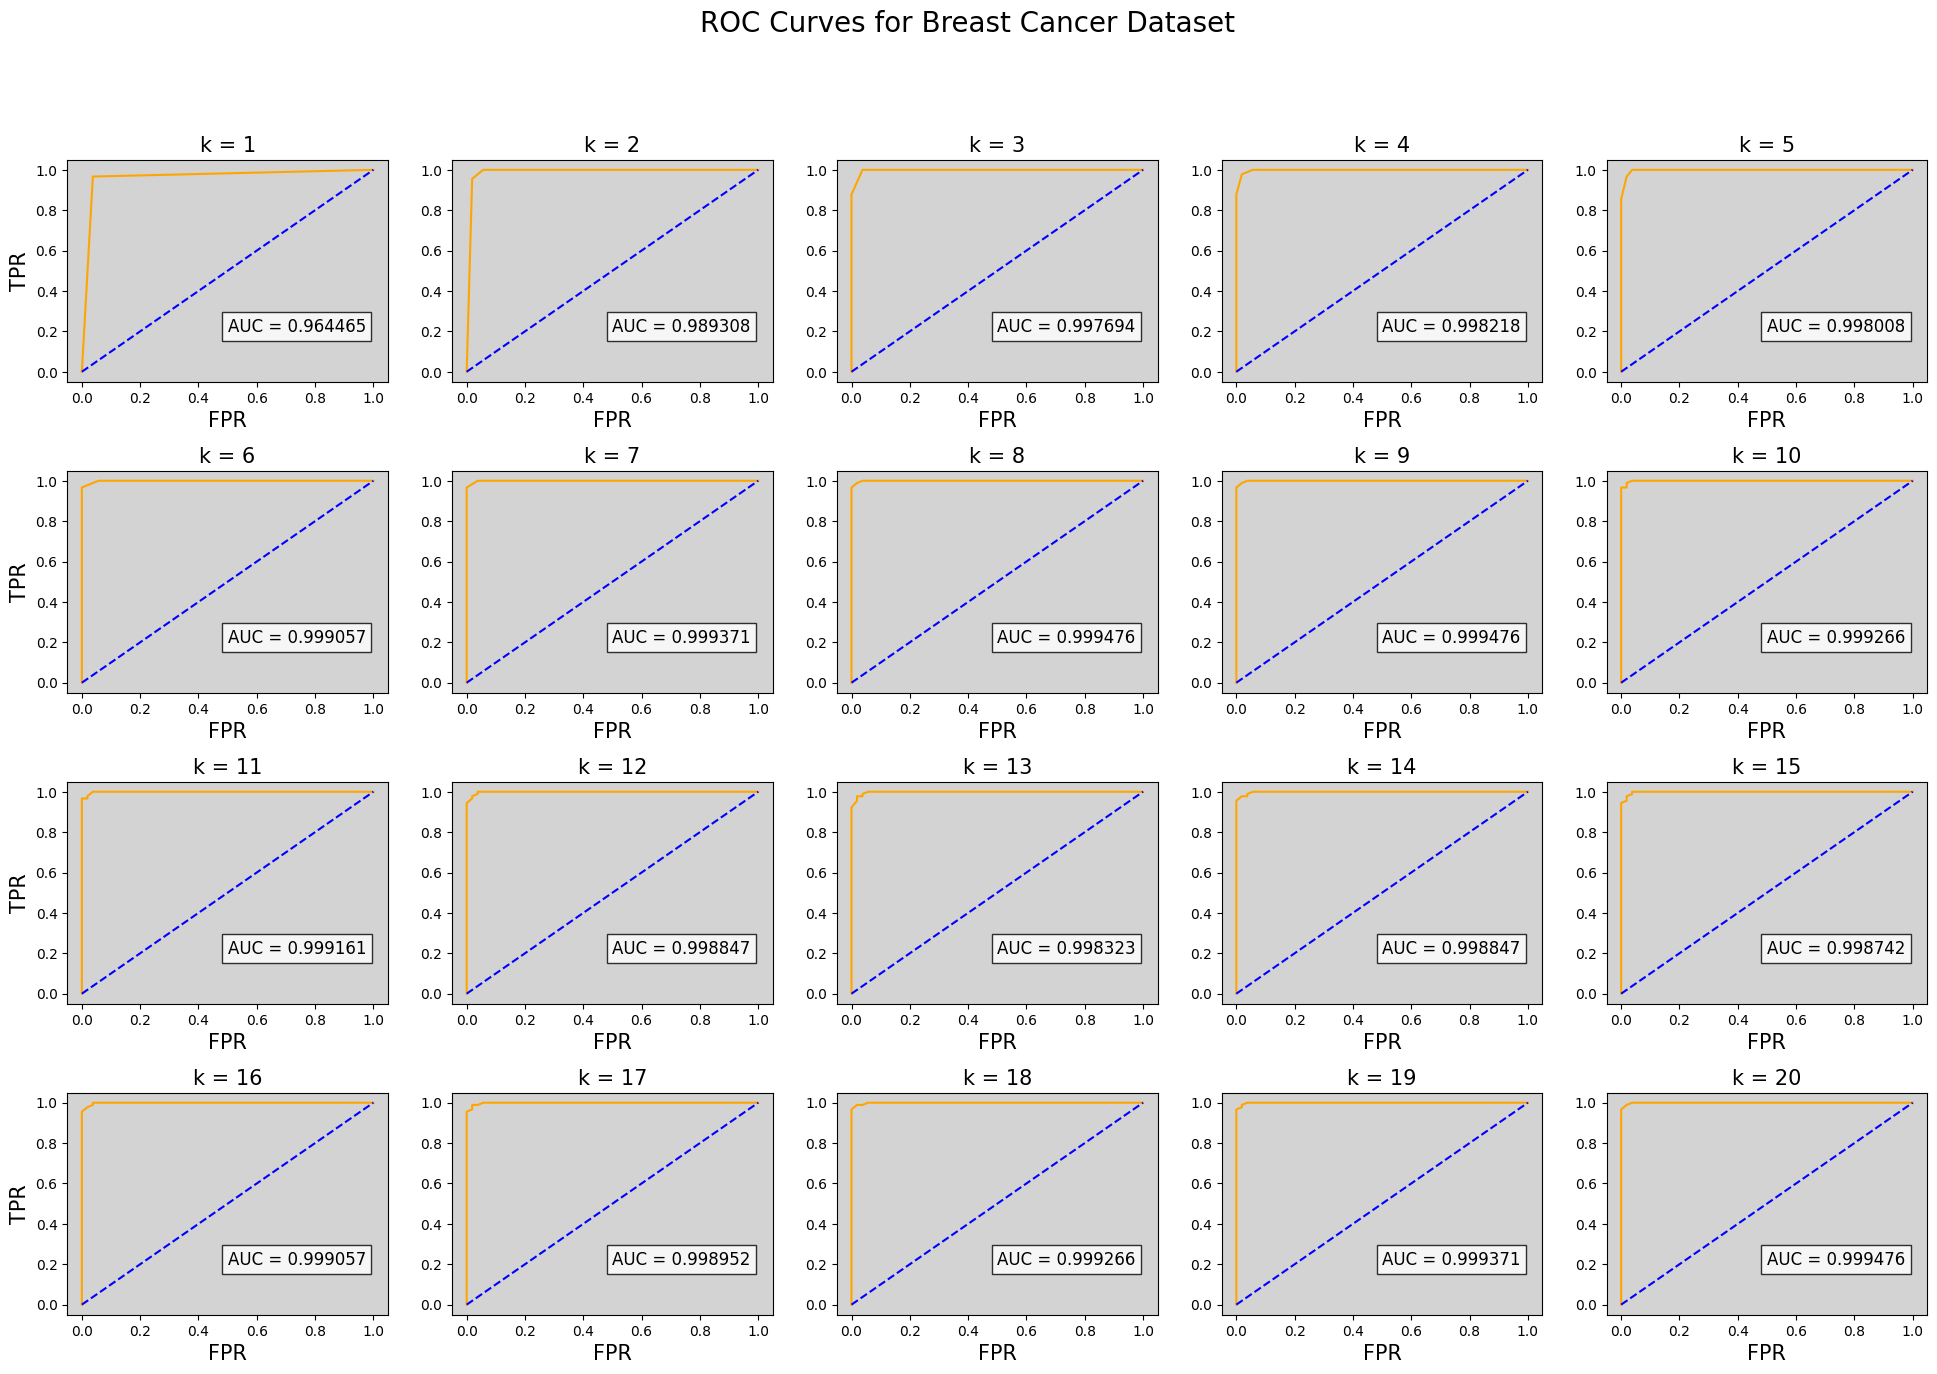

In [10]:
from sklearn.metrics import roc_curve, auc

# Load breast cancer dataset and split into training and test set
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# Select k-values in the range from 1 to 25
k_values = np.arange(1, 21)
pos_probs = np.zeros_like(k_values)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(24, 15))

for i, (k, ax) in enumerate(zip(k_values, axes.flatten())):
    # Instantiate the KNN classifier & Standard scaler
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    scaler = StandardScaler()

    model = Pipeline([
                    ("scaler", scaler),
                    ("knn", knn)
                    ])

    # Fit model
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute the ROC curve
    fp_rate, tp_rate, thresholds = roc_curve(y_test, y_prob)

    # Plot the ROC curve
    ax.plot(fp_rate, tp_rate, color='orange')

    if i%5 == 0:
        ax.set_ylabel("TPR", fontsize=15)

    ax.set_xlabel("FPR", fontsize=15)
    
    # Set k-value as title
    ax.set_title(f"k = {k}", fontsize=15)
    
    # Plot random classifier line
    ax.plot([0, 1], [0, 1], color='blue', linestyle='dashed')

    ax.set_facecolor("LightGray")

    # Compute the AUC
    roc_auc = auc(fp_rate, tp_rate)

    # Annotate the plot with AUC score
    ax.text(0.5, 0.2, f"AUC = {roc_auc:.6f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

fig.suptitle("ROC Curves for Breast Cancer Dataset", fontsize=20)
plt.subplots_adjust(hspace=0.4)
plt.show()

### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


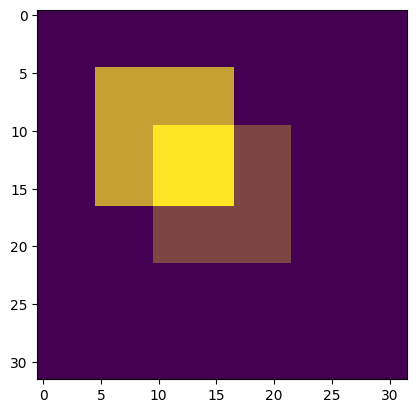

In [11]:
# generate some test objecys
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>

### Equivalence of $F_1$ Score and Dice Similarity Coefficient

The $F_1$ score and the Dice Similarity Coefficient (DSC) are both measures used to evaluate the performance of classification models, particularly in binary classification tasks. Both metrics measure the overlap between the predicted positive set and the true positive set. Here, we show that the $F_1$ score is equivalent to the Dice Similarity Coefficient.

#### Definitions

1. **Precision**: The ratio of correctly predicted positive observations to the total predicted positive observations.
   \begin{align}
   \text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
   \end{align}

2. **Recall (Sensitivity)**: The ratio of correctly predicted positive observations to all observations in the actual class.
   \begin{align}
   \text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
   \end{align}

3. **$F_1$ Score**: The harmonic mean of precision and recall.
   \begin{align}
   F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
   \end{align}

4. **Dice Similarity Coefficient (DSC)**: A measure of overlap between two sets, defined for binary classification as:
   \begin{align}
   \text{DSC} = \frac{2 \cdot \text{TP}}{2 \cdot \text{TP} + \text{FP} + \text{FN}}
   \end{align}

#### Proof of Equivalence

To show that the $F_1$ score is equivalent to the Dice Similarity Coefficient, let's express both in terms of the same variables:

**Step 1: Express $F_1$ Score in Terms of TP, FP, and FN**

Substituting precision and recall into the formula for the $F_1$ score:

\begin{align}
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
\end{align}

Substituting the definitions of precision and recall:

\begin{align}
F_1 = 2 \cdot \frac{\left(\frac{\text{TP}}{\text{TP} + \text{FP}}\right) \cdot \left(\frac{\text{TP}}{\text{TP} + \text{FN}}\right)}{\left(\frac{\text{TP}}{\text{TP} + \text{FP}}\right) + \left(\frac{\text{TP}}{\text{TP} + \text{FN}}\right)}
\end{align}

Simplify the numerator:

\begin{align}
F_1 = 2 \cdot \frac{\frac{\text{TP} \cdot \text{TP}}{(\text{TP} + \text{FP})(\text{TP} + \text{FN})}}{\frac{\text{TP} (\text{TP} + \text{FN}) + \text{TP} (\text{TP} + \text{FP})}{(\text{TP} + \text{FP})(\text{TP} + \text{FN})}}
\end{align}

\begin{align}
F_1 = 2 \cdot \frac{\text{TP}^2}{\text{TP} \cdot (\text{TP} + \text{FN}) + \text{TP} \cdot (\text{TP} + \text{FP})}
\end{align}

\begin{align}
F_1 = 2 \cdot \frac{\text{TP}^2}{\text{TP}^2 + \text{TP} \cdot \text{FN} + \text{TP}^2 + \text{TP} \cdot \text{FP}}
\end{align}

\begin{align}
F_1 = 2 \cdot \frac{\text{TP}^2}{2 \cdot \text{TP}^2 + \text{TP} \cdot \text{FN} + \text{TP} \cdot \text{FP}}
\end{align}

Simplify further:

\begin{align}
F_1 = 2 \cdot \frac{\text{TP}}{2 \cdot \text{TP} + \text{FP} + \text{FN}}
\end{align}

**Step 2: Express DSC**

\begin{align}
\text{DSC} = \frac{2 \cdot \text{TP}}{2 \cdot \text{TP} + \text{FP} + \text{FN}}
\end{align}

From the formulas, it is clear that:

\begin{align}
F_1 = \text{DSC}
\end{align}

Thus, the $F_1$ score is equivalent to the Dice Similarity Coefficient. Both metrics measure the same concept: the overlap between the predicted positive set and the true positive set, with a balanced emphasis on precision and recall.
